## Import Packages

In [1]:
from spo.data import knapsack, dataset
from spo.model import knapsackModel
from spo.func import blackboxOpt
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(135)

## Init Data

In [4]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, cor=False)

## Build Model 

In [5]:
# model for shortest path
cap = 30
ks_model = knapsackModel(weights, cap)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [6]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
def train(dataloader, opt_model, num_epochs, learning_rate, lambd=20, l1_lambda=1e-3):
    """
    train model with Black-Box Optimizer
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      lambda: black-box optimizer parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.SGD(lr.parameters(), lr=learning_rate)
    # set loss
    criterion = nn.L1Loss()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = lr(x)
            # black-box optimizer
            wp = blackboxOpt.apply(opt_model, cp, lambd)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # l1 loss
            loss = criterion(zp, z)
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [8]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [9]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [10]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3
        num_epochs = 600
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 314.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [05:20<00:00,  1.87it/s]


Normalized SPO Loss: 5.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.25it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [05:40<00:00,  1.76it/s]


Normalized SPO Loss: 8.77%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [05:46<00:00,  1.73it/s]


Normalized SPO Loss: 9.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [05:58<00:00,  1.67it/s]


Normalized SPO Loss: 14.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:28<00:00,  1.54it/s]


Normalized SPO Loss: 5.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 291.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:07<00:00,  1.40it/s]


Normalized SPO Loss: 6.60%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 307.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.48it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:00<00:00,  1.43it/s]


Normalized SPO Loss: 8.03%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 272.59it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:09<00:00,  1.40it/s]


Normalized SPO Loss: 12.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 298.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:11<00:00,  1.39it/s]


Normalized SPO Loss: 4.92%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 260.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:14<00:00,  1.38it/s]


Normalized SPO Loss: 5.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 257.76it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 275.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:02<00:00,  1.42it/s]


Normalized SPO Loss: 10.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 275.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:09<00:00,  1.40it/s]


Normalized SPO Loss: 16.93%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 282.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:08<00:00,  1.40it/s]


Normalized SPO Loss: 5.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 272.83it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:18<00:00,  1.37it/s]


Normalized SPO Loss: 7.49%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 298.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:18<00:00,  1.37it/s]


Normalized SPO Loss: 8.98%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 268.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:09<00:00,  1.40it/s]


Normalized SPO Loss: 16.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 287.89it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:35<00:00,  1.32it/s]


Normalized SPO Loss: 3.42%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 253.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:51<00:00,  1.27it/s]


Normalized SPO Loss: 7.59%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 280.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [08:15<00:00,  1.21it/s]


Normalized SPO Loss: 10.94%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 267.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:54<00:00,  1.26it/s]


Normalized SPO Loss: 17.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 281.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.77it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:46<00:00,  1.29it/s]


Normalized SPO Loss: 4.64%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 270.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 219.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:54<00:00,  1.27it/s]


Normalized SPO Loss: 7.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 223.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.76it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:54<00:00,  1.26it/s]


Normalized SPO Loss: 9.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 273.01it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.87it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:52<00:00,  1.27it/s]


Normalized SPO Loss: 16.27%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [07:01<00:00,  1.42it/s]


Normalized SPO Loss: 5.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:39<00:00,  1.50it/s]


Normalized SPO Loss: 7.80%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 246.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:28<00:00,  1.54it/s]


Normalized SPO Loss: 12.68%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 257.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:38<00:00,  1.51it/s]


Normalized SPO Loss: 13.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 259.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 273.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:46<00:00,  1.48it/s]


Normalized SPO Loss: 6.19%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 301.41it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:32<00:00,  1.53it/s]


Normalized SPO Loss: 8.90%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 264.45it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:30<00:00,  1.54it/s]


Normalized SPO Loss: 9.26%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 306.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:22<00:00,  1.57it/s]


Normalized SPO Loss: 15.81%



The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


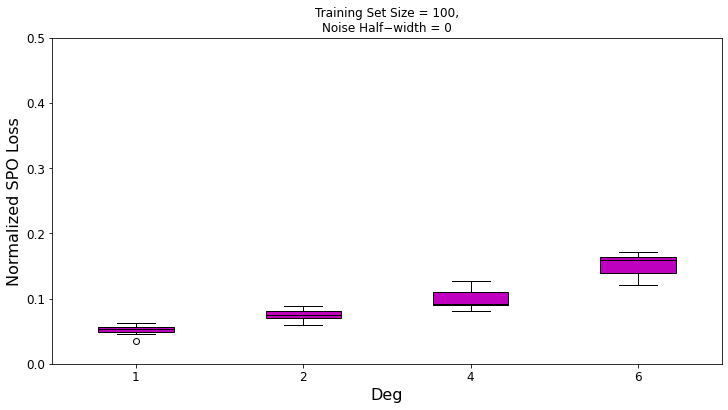

In [11]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [12]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [13]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [14]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3
        num_epochs = 600
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 323.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:38<00:00,  1.50it/s]


Normalized SPO Loss: 21.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 319.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.26it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:45<00:00,  1.48it/s]


Normalized SPO Loss: 18.61%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 264.00it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:34<00:00,  1.52it/s]


Normalized SPO Loss: 19.05%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 262.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:26<00:00,  1.55it/s]


Normalized SPO Loss: 22.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 359.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:22<00:00,  1.57it/s]


Normalized SPO Loss: 21.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 270.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:22<00:00,  1.57it/s]


Normalized SPO Loss: 18.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 303.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:23<00:00,  1.57it/s]


Normalized SPO Loss: 18.56%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.99it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:22<00:00,  1.57it/s]


Normalized SPO Loss: 19.49%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 299.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:25<00:00,  1.56it/s]


Normalized SPO Loss: 17.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:16<00:00,  1.59it/s]


Normalized SPO Loss: 16.45%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 303.68it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:32<00:00,  1.53it/s]


Normalized SPO Loss: 19.62%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 329.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:24<00:00,  1.56it/s]


Normalized SPO Loss: 24.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 356.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:09<00:00,  1.62it/s]


Normalized SPO Loss: 22.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 247.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.52it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:09<00:00,  1.62it/s]


Normalized SPO Loss: 21.04%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 336.44it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.78it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:05<00:00,  1.64it/s]


Normalized SPO Loss: 20.01%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 311.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 335.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:08<00:00,  1.63it/s]


Normalized SPO Loss: 21.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:13<00:00,  1.61it/s]


Normalized SPO Loss: 21.85%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 250.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:07<00:00,  1.63it/s]


Normalized SPO Loss: 20.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.32it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:08<00:00,  1.63it/s]


Normalized SPO Loss: 19.38%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:01<00:00,  1.66it/s]


Normalized SPO Loss: 22.70%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 342.16it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:06<00:00,  1.64it/s]


Normalized SPO Loss: 18.94%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 291.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:11<00:00,  1.61it/s]


Normalized SPO Loss: 17.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 308.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.40it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:10<00:00,  1.62it/s]


Normalized SPO Loss: 18.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:11<00:00,  1.61it/s]


Normalized SPO Loss: 23.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:13<00:00,  1.61it/s]


Normalized SPO Loss: 21.89%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 379.80it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:14<00:00,  1.60it/s]


Normalized SPO Loss: 22.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 306.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:13<00:00,  1.61it/s]


Normalized SPO Loss: 22.15%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 317.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:04<00:00,  1.65it/s]


Normalized SPO Loss: 20.55%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.46it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:03<00:00,  1.65it/s]


Normalized SPO Loss: 20.65%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.57it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:06<00:00,  1.64it/s]


Normalized SPO Loss: 19.60%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:09<00:00,  1.63it/s]


Normalized SPO Loss: 18.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 600/600 [06:06<00:00,  1.64it/s]


Normalized SPO Loss: 22.28%



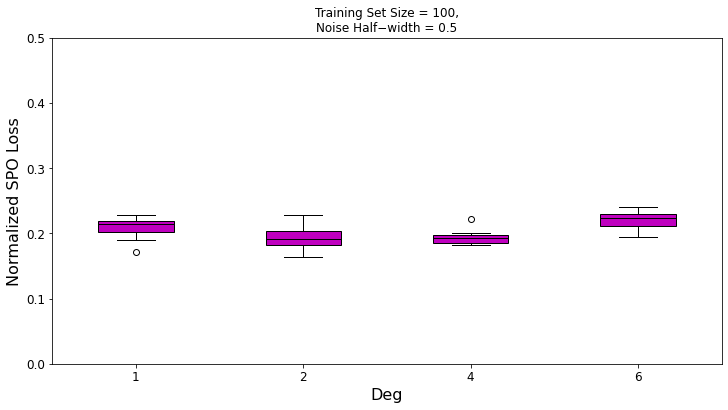

In [15]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0 

In [16]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [17]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [18]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3
        num_epochs = 200
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.79it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:16<00:00,  6.08s/it]


Normalized SPO Loss: 0.54%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 345.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.26it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:44<00:00,  6.22s/it]


Normalized SPO Loss: 1.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:53<00:00,  6.27s/it]


Normalized SPO Loss: 1.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:34<00:00,  6.17s/it]


Normalized SPO Loss: 1.96%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 326.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:04<00:00,  6.02s/it]


Normalized SPO Loss: 1.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.55it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.14it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:36<00:00,  6.18s/it]


Normalized SPO Loss: 1.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:26<00:00,  6.13s/it]


Normalized SPO Loss: 1.30%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:27<00:00,  6.14s/it]


Normalized SPO Loss: 1.20%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.49it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:43<00:00,  6.22s/it]


Normalized SPO Loss: 0.90%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 307.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [21:16<00:00,  6.38s/it]


Normalized SPO Loss: 1.14%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [22:16<00:00,  6.68s/it]


Normalized SPO Loss: 1.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.56it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [21:14<00:00,  6.37s/it]


Normalized SPO Loss: 1.72%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 299.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [21:18<00:00,  6.39s/it]


Normalized SPO Loss: 0.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:22<00:00,  6.11s/it]


Normalized SPO Loss: 1.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.53it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:17<00:00,  6.09s/it]


Normalized SPO Loss: 1.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:10<00:00,  6.05s/it]


Normalized SPO Loss: 2.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.56it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:14<00:00,  6.07s/it]


Normalized SPO Loss: 0.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.06it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.78it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:03<00:00,  6.02s/it]


Normalized SPO Loss: 1.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:53<00:00,  6.27s/it]


Normalized SPO Loss: 1.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.45it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:13<00:00,  6.07s/it]


Normalized SPO Loss: 1.51%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 329.07it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:27<00:00,  6.14s/it]


Normalized SPO Loss: 1.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:32<00:00,  6.16s/it]


Normalized SPO Loss: 0.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 318.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:37<00:00,  6.19s/it]


Normalized SPO Loss: 1.61%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.40it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [21:01<00:00,  6.31s/it]


Normalized SPO Loss: 1.68%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.47it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [21:08<00:00,  6.34s/it]


Normalized SPO Loss: 1.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:40<00:00,  6.20s/it]


Normalized SPO Loss: 1.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.24it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:38<00:00,  6.19s/it]


Normalized SPO Loss: 1.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:31<00:00,  6.16s/it]


Normalized SPO Loss: 1.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:29<00:00,  6.15s/it]


Normalized SPO Loss: 0.89%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:47<00:00,  6.24s/it]


Normalized SPO Loss: 0.82%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:32<00:00,  6.16s/it]


Normalized SPO Loss: 1.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [21:00<00:00,  6.30s/it]


Normalized SPO Loss: 2.47%



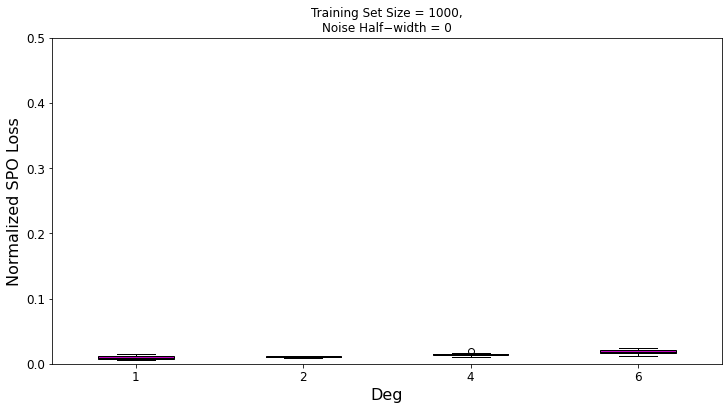

In [19]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 1000, Noise Half−width = 0.5 

In [20]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [21]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [22]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        weights, x, c = knapsack.genData(n+1000, p, m, deg=deg, noise_width=e, seed=i)
        c = - c
        # build model
        ks_model = knapsackModel(weights, cap)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        ks_dataset_train = dataset.optDataset(ks_model, x_train, c_train)
        ks_dataset_test = dataset.optDataset(ks_model, x_test, c_test)
        # get data loader
        batch_size = 32
        ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
        ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3
        num_epochs = 200
        lr = train(ks_loader_train, ks_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, ks_model, ks_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.91it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:37<00:00,  6.19s/it]


Normalized SPO Loss: 15.99%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:50<00:00,  6.25s/it]


Normalized SPO Loss: 13.62%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.50it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:26<00:00,  6.13s/it]


Normalized SPO Loss: 9.24%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.37it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 297.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:24<00:00,  6.12s/it]


Normalized SPO Loss: 7.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.17it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:34<00:00,  6.17s/it]


Normalized SPO Loss: 17.87%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:35<00:00,  6.18s/it]


Normalized SPO Loss: 14.61%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 312.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [19:55<00:00,  5.98s/it]


Normalized SPO Loss: 8.45%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:41<00:00,  5.31s/it]


Normalized SPO Loss: 6.75%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.96it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:34<00:00,  5.27s/it]


Normalized SPO Loss: 15.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 380.86it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.29it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:41<00:00,  5.31s/it]


Normalized SPO Loss: 15.41%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.13it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [18:09<00:00,  5.45s/it]


Normalized SPO Loss: 10.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:58<00:00,  5.39s/it]


Normalized SPO Loss: 8.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [19:14<00:00,  5.77s/it]


Normalized SPO Loss: 16.64%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.63it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:58<00:00,  5.39s/it]


Normalized SPO Loss: 15.23%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.55it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [18:05<00:00,  5.43s/it]


Normalized SPO Loss: 9.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.80it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:39<00:00,  5.30s/it]


Normalized SPO Loss: 7.47%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.60it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:37<00:00,  5.29s/it]


Normalized SPO Loss: 18.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:53<00:00,  5.37s/it]


Normalized SPO Loss: 14.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 353.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:44<00:00,  5.32s/it]


Normalized SPO Loss: 9.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 368.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:38<00:00,  5.29s/it]


Normalized SPO Loss: 6.78%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 360.64it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [17:39<00:00,  5.30s/it]


Normalized SPO Loss: 16.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 370.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [19:58<00:00,  5.99s/it]


Normalized SPO Loss: 13.71%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:41<00:00,  6.21s/it]


Normalized SPO Loss: 9.55%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.47it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [19:45<00:00,  5.93s/it]


Normalized SPO Loss: 7.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:02<00:00,  6.01s/it]


Normalized SPO Loss: 18.00%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.49it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [19:58<00:00,  5.99s/it]


Normalized SPO Loss: 15.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 338.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:29<00:00,  6.15s/it]


Normalized SPO Loss: 10.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 334.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [19:35<00:00,  5.88s/it]


Normalized SPO Loss: 8.31%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.00it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:11<00:00,  6.06s/it]


Normalized SPO Loss: 15.67%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 300.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 302.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:53<00:00,  6.27s/it]


Normalized SPO Loss: 14.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 283.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [21:19<00:00,  6.40s/it]


Normalized SPO Loss: 9.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.69it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.67it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 200/200 [20:52<00:00,  6.26s/it]


Normalized SPO Loss: 7.93%



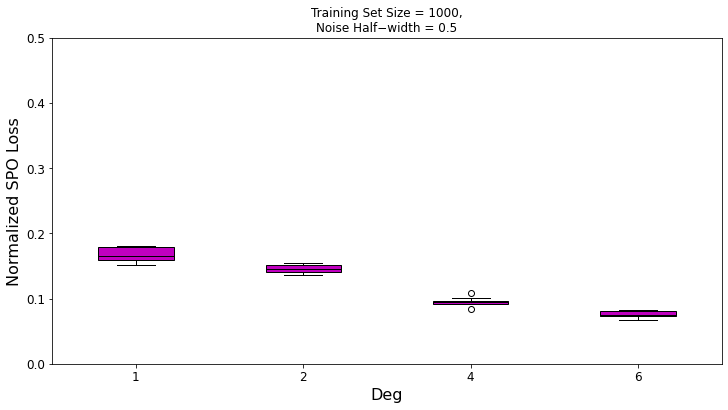

In [23]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='m', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [24]:
df1.to_csv('./res/ks/blackbox_n100.csv', index=False)
df2.to_csv('./res/ks/blackbox_n100_noise.csv', index=False)
df3.to_csv('./res/ks/blackbox_n1000.csv', index=False)
df4.to_csv('./res/ks/blackbox_n1000_noise.csv', index=False)